In [1]:
# imports
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [2]:
#install tensorflow with conda
#conda install -c conda-forge tensorflow

import tensorflow as tf

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [4]:
import keras as keras

In [5]:
print("Keras version:", keras.__version__)

Keras version: 3.5.0


In [7]:
# tensorflow imports
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
root_dir = Path.cwd()
root_dir = Path('/content/drive/MyDrive/Lambton/ai_lab')

# Define the images directory
images_dir = root_dir / 'data' / 'images'

# Define the output directories
train_dir = root_dir / 'data' / 'training'
test_dir = root_dir / 'data' / 'test'

# Define the classes based on filename prefixes
classes = ['level0', 'level1', 'level2', 'level3']

prefix_mapping = {
    'level0': 'levle0_',
    'level1': 'levle1_',
    'level2': 'levle2_',
    'level3': 'levle3_'
}


In [10]:
# ensures that the training and test directories, along with their class subdirectories, exist.

for split_dir in [train_dir, test_dir]:
    for cls in classes:
        class_path = split_dir / cls
        class_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# Function to Split and Copy Images
def split_and_copy_images():
    for cls in classes:
        # Get the corresponding prefix for the current class
        cls_prefix = prefix_mapping.get(cls)

        if not cls_prefix:
            print(f"No prefix defined for class '{cls}'. Skipping.")
            continue

        # Retrieve all images belonging to the current class
        cls_images = [img for img in images_dir.iterdir() if img.is_file() and img.name.startswith(cls_prefix)]

        # Split the images into training and testing sets (75% train, 25% test)
        train_images, test_images = train_test_split(
            cls_images,
            test_size=0.25,
            random_state=42,  # Ensures reproducibility
            shuffle=True
        )

        # Copy training images
        for img_path in train_images:
            destination = train_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        # Copy testing images
        for img_path in test_images:
            destination = test_dir / cls / img_path.name
            shutil.copy(img_path, destination)

        print(f"Class '{cls}': {len(train_images)} training and {len(test_images)} testing images copied.")

# Execute the function
split_and_copy_images()

print("All images have been successfully split into training and test sets.")

Class 'level0': 375 training and 126 testing images copied.


In [ ]:
# Get the class names for our multi-class dataset
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))
print(class_names)

['level0' 'level1' 'level2' 'level3']


In [ ]:
!pip install pathlib

import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split


root_dir = Path.cwd()
# If your data is in Google Drive, uncomment the line below and adjust the path
root_dir = Path('/content/drive/MyDrive/Lambton/ai_lab')

# Define the images directory relative to the root directory
images_dir = root_dir / 'data' / 'images'

# Check if the images directory exists and if not, create it
if not images_dir.exists():
    images_dir.mkdir(parents=True, exist_ok=True)
    print(f"Created directory: {images_dir}")
else:
    print(f"Directory already exists: {images_dir}")

# Rest of your code (defining train_dir, test_dir, classes, prefix_mapping, split_and_copy_images function) remains the same
# ...

Directory already exists: /content/drive/MyDrive/Lambton/ai_lab/data/images


In [ ]:
# # View an image
# def view_random_image(target_dir, target_class):
#   # Setup target directory (we'll view images from here)
#   target_folder = Path(target_dir) / target_class

#   # Get a random image path
#   random_image = random.sample(os.listdir(target_folder), 1)[0]

#   # Read in the image and plot it using matplotlib
#   img = mpimg.imread(target_folder / random_image)
#   plt.imshow(img)
#   plt.title(target_class)
#   plt.axis("off")

#   print(f"Image shape: {img.shape}") # show the shape of the image

#   return img
import os
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from pathlib import Path

# View an image
def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = Path(target_dir) / target_class

    # Check if the target folder exists and contains files
    if not target_folder.exists() or not os.listdir(target_folder):
        print(f"No images found in {target_folder}. Skipping.")
        return None  # Or raise an exception if desired

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)[0]

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder / random_image)
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")  # show the shape of the image

    return img

Image shape: (3264, 4912, 3)


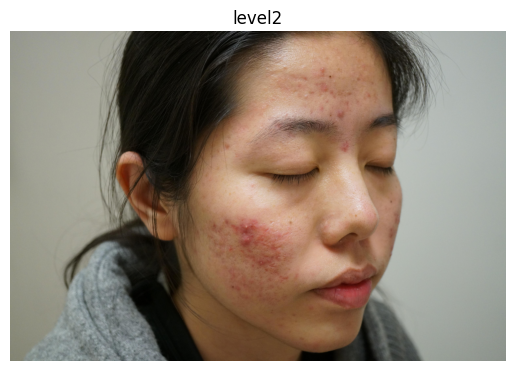

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(classes)) # get a random class name

## Transfer learning test

In [ ]:
# Create datasets using image_dataset_from_directory
train_data = keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 image_size=(224, 224),
                                                                 batch_size=32,
                                                                 label_mode='categorical', # for multi-class classification
                                                                 shuffle=True)

test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                batch_size=32,
                                                                label_mode='categorical')

# Data augmentation
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
])

# Normalization layer
normalization_layer = keras.layers.Rescaling(1./255)

# Apply data augmentation and normalization to training data
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))

# Apply normalization to test data
test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

# Prefetch data for better performance (overlap data preprocessing and model execution)
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
test_data = test_data.prefetch(buffer_size=AUTOTUNE)


Found 1366 files belonging to 4 classes.
Found 638 files belonging to 4 classes.


In [ ]:
import os
print(os.listdir('/content/data/training')) # Print the contents of the directory

['level0', 'level1', 'level2', 'level3']


In [ ]:
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Transfer learning: use pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model to prevent training
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps to a single vector
    Dropout(0.3),              # Add dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),              # Another dropout layer
    Dense(4, activation='softmax')  # Output layer for 4 acne severity classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



In [ ]:
# Train the model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=40,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 196s 4s/step - accuracy: 0.3776 - loss: 1.5116 - val_accuracy: 0.4655 - val_loss: 1.0737 - learning_rate: 0.0010
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5042 - loss: 1.0274 - val_accuracy: 0.4451 - val_loss: 0.9993 - learning_rate: 0.0010
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4905 - loss: 1.0242 - val_accuracy: 0.5282 - val_loss: 0.9429 - learning_rate: 0.0010
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5489 - loss: 0.9425 - val_accuracy: 0.6003 - val_loss: 0.8956 - learning_rate: 0.0010
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.5405 - loss: 0.9270 - val_accuracy: 0.5674 - val_loss: 0.8915 - learning_rate: 0.0010
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.5567 - loss: 0.9281 - val_accuracy: 0.6050 - val_loss: 0.8538 - learning_rate: 0.0010
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.5569 - loss: 0.9213 - val_accuracy

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6838 - loss: 0.7475
Test accuracy: 0.65


### ResNet50

In [ ]:
from keras.applications import ResNet50

# Use ResNet50 instead of MobileNetV2
base_model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the new model
model_RN = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Compile the model
model_RN.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Train the model
history = model_RN.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.3586 - loss: 1.4978 - val_accuracy: 0.4232 - val_loss: 1.2383 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.3986 - loss: 1.2476 - val_accuracy: 0.4232 - val_loss: 1.2532 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.4255 - loss: 1.2136 - val_accuracy: 0.4248 - val_loss: 1.2274 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4288 - loss: 1.2298 - val_accuracy: 0.4248 - val_loss: 1.2317 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.4523 - loss: 1.2096 - val_accuracy: 0.4248 - val_loss: 1.2249 - learning_rate: 0.0010


In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_RN.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4117 - loss: 1.2524
Test accuracy: 0.42


### EfficientNetB0

In [ ]:
from keras.applications import EfficientNetB0

# Transfer learning: use pre-trained MobileNetV2 model
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model to prevent training
base_model.trainable = False

# Build the model
model_EN = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Pool the feature maps to a single vector
    Dropout(0.3),              # Add dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dropout(0.3),              # Another dropout layer
    Dense(4, activation='softmax')  # Output layer for 4 acne severity classes
])

# Compile the model
model_EN.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Train the model
history = model_EN.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4180 - loss: 1.2510 - val_accuracy: 0.4248 - val_loss: 1.2349 - learning_rate: 0.0010
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.4219 - loss: 1.2145 - val_accuracy: 0.4248 - val_loss: 1.2382 - learning_rate: 0.0010
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4286 - loss: 1.2156 - val_accuracy: 0.4248 - val_loss: 1.2307 - learning_rate: 0.0010
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4469 - loss: 1.2028 - val_accuracy: 0.4248 - val_loss: 1.2268 - learning_rate: 0.0010
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4504 - loss: 1.2110 - val_accuracy: 0.4248 - val_loss: 1.2220 - learning_rate: 0.0010
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4200 - loss: 1.2068 - val_accuracy: 0.4248 - val_loss: 1.2210 - learning_rate: 0.0010
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4330 - loss: 1.2062 - val_accuracy

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model_RN.evaluate(test_data)
print(f"Test accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4338 - loss: 1.2322
Test accuracy: 0.42


### Random Search

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.applications import MobileNetV2
from keras.optimizers import Adam
import keras_tuner as kt

# Define a function to build the model
def build_model(hp):
    # Transfer learning: use pre-trained MobileNetV2 model
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(hp.Int('units', min_value=64, max_value=256, step=64), activation='relu'),
        Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(4, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Set up the KerasTuner for hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='acne_classification'
)

# Callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Determine the size of the dataset
dataset_size = train_data.cardinality().numpy()

# Define the split ratio
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

# Split the dataset
train_dataset = train_data.take(train_size)
val_dataset = train_data.skip(train_size)

# Perform the search with KerasTuner
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[lr_scheduler, early_stopping]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 1 Complete [00h 36m 01s]
val_accuracy: 0.6474820375442505

Best val_accuracy So Far: 0.6474820375442505
Total elapsed time: 00h 36m 01s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
0.2               |0.4               |dropout1
128               |192               |units
0.2               |0.2               |dropout2
0.00010278        |0.0001975         |learning_rate

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3493 - loss: 1.5214

KeyboardInterrupt: 

## Normal training

In [ ]:
# Create baseline model
model_baseline = Sequential([
    Input(shape=(224, 224, 3)),  # Define input shape using Input layer
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),  # Increased dropout before output layer
    Dense(4, activation='softmax')  # 4 neurons for the 4 classes
])

# Compile the model with a learning rate scheduler
model_baseline.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


model_baseline.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 110, 110, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 108, 108, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 51, 51, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 51, 51, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 49, 49, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 296,420 (1.13 MB)

 Trainable params: 295,972 (1.13 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.5,
                                 patience=3,
                                 verbose=1,
                                 min_lr=1e-6)

# Optional: Set up a model checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

In [ ]:
# Fit the model with callbacks
history = model_baseline.fit(train_data,
                         epochs=10,
                         validation_data=test_data,
                         callbacks=[lr_scheduler, checkpoint])

Epoch 1/10


KeyboardInterrupt: 

Extraction of lables

In [ ]:
import os
from pathlib import Path


# Function to extract labels from the training directory
def extract_labels(data_dir):
    labels = []
    image_paths = []

    for cls in os.listdir(data_dir):
        cls_path = data_dir / cls
        if cls_path.is_dir():
            for img_file in os.listdir(cls_path):
                image_paths.append(str(cls_path / img_file))
                labels.append(cls)  # Append the class name as the label

    return image_paths, labels

# Extract labels for training and testing data
train_image_paths, train_labels = extract_labels(train_dir)
test_image_paths, test_labels = extract_labels(test_dir)

# Print the first few extracted labels
print(f"Sample train labels: {train_labels[:5]}")
print(f"Sample train image paths: {train_image_paths[:5]}")


Sample train labels: ['level3', 'level3', 'level3', 'level3', 'level3']
Sample train image paths: ['/content/drive/MyDrive/Lambton/ai_lab/data/training/level3/levle3_90.jpg', '/content/drive/MyDrive/Lambton/ai_lab/data/training/level3/levle3_59.jpg', '/content/drive/MyDrive/Lambton/ai_lab/data/training/level3/levle3_44.jpg', '/content/drive/MyDrive/Lambton/ai_lab/data/training/level3/levle3_45.jpg', '/content/drive/MyDrive/Lambton/ai_lab/data/training/level3/levle3_16.jpg']


Dealing with classimbalance using: Data Augumentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the ImageDataGenerator for oversampling
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a flow from the training data
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on your model input size
    class_mode='categorical',  # Use 'binary' if you have two classes
    batch_size=32,
    shuffle=True
)

# You can also balance your classes here
# For example, you can determine the class counts and perform manual oversampling
from collections import Counter
import numpy as np

# Count the occurrences of each label
label_counts = Counter(train_labels)
max_count = max(label_counts.values())

# Create balanced data by oversampling
balanced_image_paths = []
balanced_labels = []

for label, count in label_counts.items():
    class_image_paths = [path for path, lbl in zip(train_image_paths, train_labels) if lbl == label]
    # Oversample until the class reaches max_count
    while len(class_image_paths) < max_count:
        balanced_image_paths.extend(class_image_paths)
        balanced_labels.extend([label] * len(class_image_paths))

# Append the remaining images to balanced lists
balanced_image_paths.extend([path for path, lbl in zip(train_image_paths, train_labels) if lbl not in label_counts])
balanced_labels.extend([lbl for lbl in train_labels if lbl not in label_counts])

# Print final counts
print("Balanced dataset size:", len(balanced_labels))


Found 1366 images belonging to 4 classes.


In [ ]:
# Evaluate on the test data
model_baseline.evaluate(test_data)

NameError: name 'model_baseline' is not defined

## Plot results

### Normal training

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    # Extract loss and accuracy from the history
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))  # Get the number of epochs

    # Plot loss
    plt.figure(figsize=(12, 5))  # Set figure size for better readability
    plt.subplot(1, 2, 1)  # Create a subplot for loss
    plt.plot(epochs, loss, label='Training Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    # Plot accuracy
    plt.subplot(1, 2, 2)  # Create a subplot for accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy', color='green')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='red')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)  # Add a grid for better visibility

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()  # Display the plots


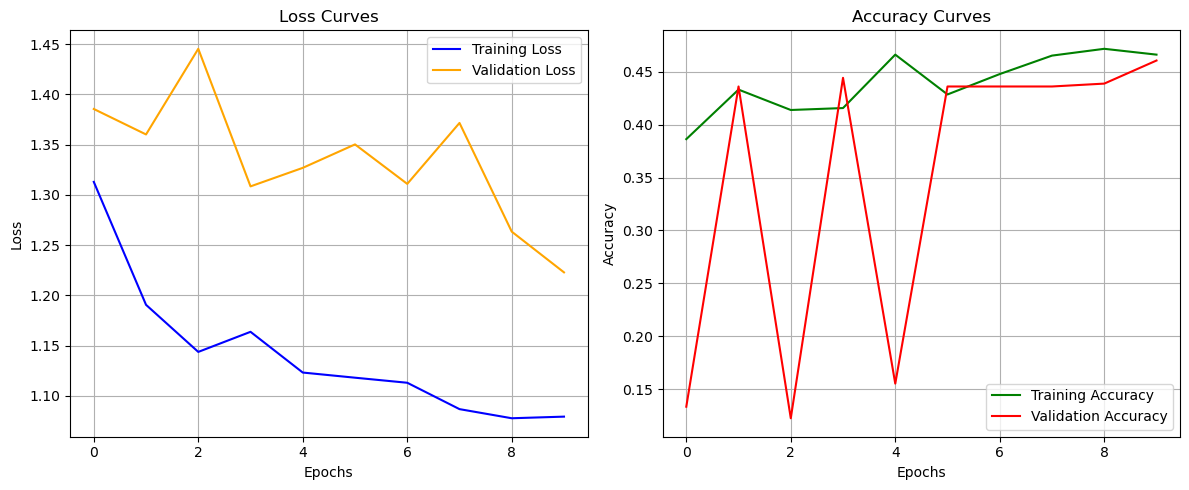

In [ ]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

### Transfer learning

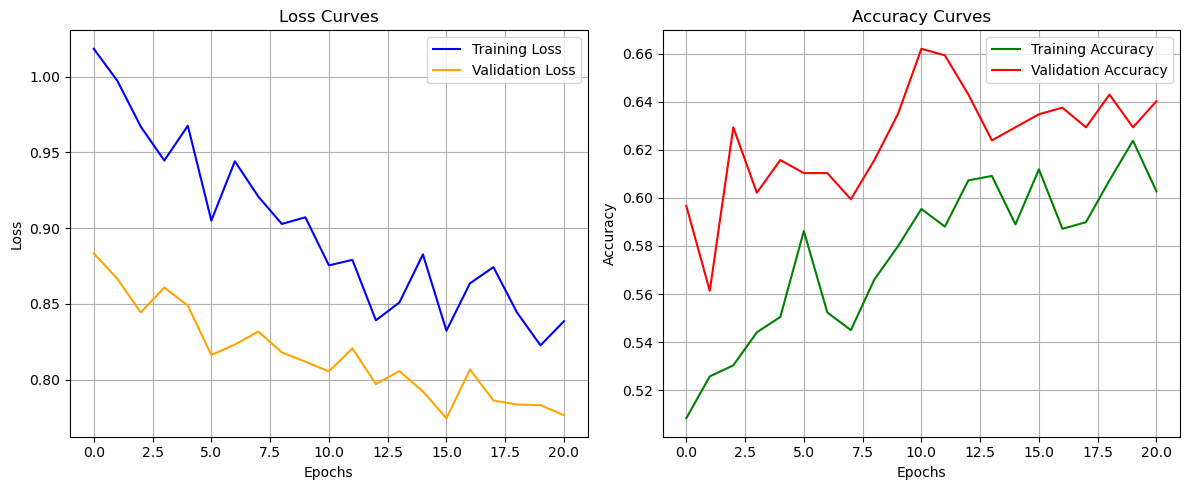

In [ ]:
# Check out the model's loss curves on the 4 classes of data
plot_loss_curves(history)

## Save model

In [ ]:
# Save the entire model
#model.save('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')  # Save the model as a .h5 file
model.save('my_acne_model.keras')  # Save the model as a .h5 file

In [ ]:
# Load the saved .keras model
from keras.models import load_model

#loaded_model = load_model('/content/drive/MyDrive/Lambton/ai_lab/my_acne_model.keras')
loaded_model = load_model('my_acne_model.keras')

In [ ]:
# Evaluate the loaded model on test data
test_loss, test_acc = loaded_model.evaluate(test_data)
print(f"Loaded .keras model test accuracy: {test_acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.6142 - loss: 0.8180
Loaded .keras model test accuracy: 0.63


In [ ]:
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,751,438 (10.50 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,970 (1.25 MB)

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


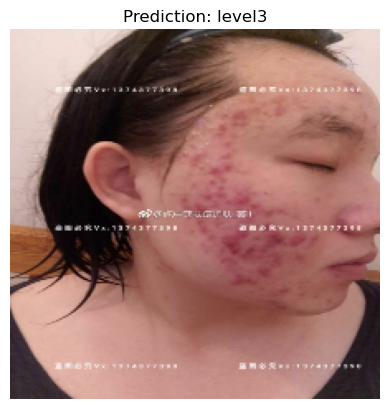

In [ ]:
# Make a prediction
test_image_path = test_dir / 'level3' / 'levle3_9.jpg'
pred_and_plot(model=loaded_model,
              filename=str(test_image_path),
              class_names=class_names)

*Lable Exatraction:


In [ ]:
import os
from pathlib import Path


# Function to extract labels from the training directory
def extract_labels(data_dir):
    labels = []
    image_paths = []

    for cls in os.listdir(data_dir):
        cls_path = data_dir / cls
        if cls_path.is_dir():
            for img_file in os.listdir(cls_path):
                image_paths.append(str(cls_path / img_file))
                labels.append(cls)  # Append the class name as the label

    return image_paths, labels

# Extract labels for training and testing data
train_image_paths, train_labels = extract_labels(train_dir)
test_image_paths, test_labels = extract_labels(test_dir)

# Print the first few extracted labels
print(f"Sample train labels: {train_labels[:5]}")
print(f"Sample train image paths: {train_image_paths[:5]}")


Class Imbalance


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the ImageDataGenerator for oversampling
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a flow from the training data
train_data_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on your model input size
    class_mode='categorical',  # Use 'binary' if you have two classes
    batch_size=32,
    shuffle=True
)

# You can also balance your classes here
# For example, you can determine the class counts and perform manual oversampling
from collections import Counter
import numpy as np

# Count the occurrences of each label
label_counts = Counter(train_labels)
max_count = max(label_counts.values())

# Create balanced data by oversampling
balanced_image_paths = []
balanced_labels = []

for label, count in label_counts.items():
    class_image_paths = [path for path, lbl in zip(train_image_paths, train_labels) if lbl == label]
    # Oversample until the class reaches max_count
    while len(class_image_paths) < max_count:
        balanced_image_paths.extend(class_image_paths)
        balanced_labels.extend([label] * len(class_image_paths))

# Append the remaining images to balanced lists
balanced_image_paths.extend([path for path, lbl in zip(train_image_paths, train_labels) if lbl not in label_counts])
balanced_labels.extend([lbl for lbl in train_labels if lbl not in label_counts])

# Print final counts
print("Balanced dataset size:", len(balanced_labels))


More preprocessing
Contrast Limited Adaptive Histogram Equalization (CLAHE) : trying to improve the contrast by redistributing intensity values.

In [ ]:
import cv2

def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return final

# Visualize CLAHE result
processed_image = apply_clahe(str(test_image_path))
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("CLAHE Processed Image")
plt.show()



Edge Detection (Sobel, Canny) :
It can help highlight acne boundaries and shape details.


In [ ]:
def apply_edge_detection(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, threshold1=100, threshold2=200)
    return edges

# Visualize edge detection
edges = apply_edge_detection(str(test_image_path))
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title("Edge Detected Image")
plt.show()




Segmentation (Superpixel or K-means)
it segments acne areas to help focus the network on relevant regions.


In [ ]:
from skimage.segmentation import slic, mark_boundaries
import matplotlib.image as mpimg

def apply_superpixel_segmentation(image_path):
    img = mpimg.imread(image_path)
    segments = slic(img, n_segments=100, compactness=10, sigma=1)
    return mark_boundaries(img, segments)

# Visualize segmentation
segmented_image = apply_superpixel_segmentation(str(test_image_path))
plt.imshow(segmented_image)
plt.axis('off')
plt.title("Segmented Image")
plt.show()



Checking if the transformations are helpful with our data

In [ ]:
augmented_image = image_gen.flow_from_directory(tf.expand_dims(img, axis=0))  # Use the `image_gen` defined earlier
plt.imshow(tf.squeeze(augmented_image).numpy())
plt.axis('off')
plt.title("Augmented Image")
plt.show()








Fine tuning base models:

In [ ]:
base_model.trainable = True
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Focal loss can help focus on harder-to-classify samples, making the model more sensitive to them.

In [ ]:
from keras.losses import CategoricalCrossentropy

# Use label smoothing with focal loss
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=loss_fn,
    metrics=['accuracy']
)


In [ ]:
# import cv2
# import matplotlib.pyplot as plt

# # Function to load and convert image to grayscale
# def load_and_convert_to_grayscale(image_path):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
#     return img

# # Path to your image
# image_path = 'your_image_path_here.jpg'

# # Convert image to grayscale
# gray_image = load_and_convert_to_grayscale(image_path)

# # Visualize the grayscale image
# plt.imshow(gray_image, cmap='gray')
# plt.axis('off')
# plt.title("Grayscale Image")
# plt.show()
